In [1]:

import pandas as pd

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer

In [39]:
random_state=42
plt.rc('font', family='serif', size=12)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('deep')
data = pd.read_csv('data_football_ratings.csv', header=0)

df = data[data['rater'] == 'WhoScored'].copy()
df = df.drop(columns=['is_human'])
df = df.sort_values(by=["player", "date"])

pd.set_option('display.max_rows', 100)
df['next_rating'] = df.groupby('player')['original_rating'].shift(-1)
df = df.dropna(subset=['next_rating'])

# Convertir la columna 'pos' a valores numéricos
position_map = {'GK': 0, 'DF': 1, 'MF': 2, 'FW': 3, 'Sub': 4}
df['pos'] = df['pos'].map(position_map)

# Características históricas
df['rating_avg_3'] = df.groupby('player')['original_rating'].transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
df['rating_trend'] = df['original_rating'] - df['rating_avg_3']

# Características de balance y ratio
df['balance_gol'] = df['goals'] - (df['goals_ag_itb'] + df['goals_ag_otb'])
df['precision_pases'] = df['passes_acc'] / (df['passes_acc'] + df['passes_inacc'] + 1)
df['ratio_duelos'] = (df['grduels_w'] + df['aerials_w']) / (df['grduels_w'] + df['grduels_l'] + df['aerials_w'] + df['aerials_l'] + 1)
df['eficacia_tiro'] = df['goals'] / (df['shots_ontarget'] + 0.1)

# Estadísticas por posición
pos_rating_avg = df.groupby('pos')['original_rating'].transform('mean')
df['pos_vs_media'] = df['original_rating'] - pos_rating_avg

# Normalización por minutos jugados (por 90 minutos)
min_jugados = df['minutesPlayed'].clip(lower=1)  # Evitar divisiones por cero
for stat in ['goals', 'assists', 'shots_ontarget', 'keypasses', 'tackles']:
    df[f'{stat}_por90'] = df[stat] * 90 / min_jugados

df.head()

# Calcula tamaños
n_total = len(df)
train_end = int(n_total * 0.7)
val_end = int(n_total * 0.85)

# División
train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

features_original = [
    'goals', 'assists', 'shots_ontarget', 'shots_offtarget', 'shotsblocked',
    'chances2score', 'drib_success', 'drib_unsuccess', 'keypasses', 'touches',
    'passes_acc', 'passes_inacc', 'crosses_acc', 'crosses_inacc',
    'lballs_acc', 'lballs_inacc', 'grduels_w', 'grduels_l',
    'aerials_w', 'aerials_l', 'poss_lost', 'fouls', 'wasfouled',
    'clearances', 'stop_shots', 'interceptions', 'tackles', 'dribbled_past',
    'tballs_acc', 'tballs_inacc', 'ycards', 'rcards', 'dangmistakes',
    'countattack', 'offsides', 'goals_ag_otb', 'goals_ag_itb',
    'saves_itb', 'saves_otb', 'saved_pen', 'missed_penalties', 'owngoals',
    'degree_centrality', 'betweenness_centrality', 'closeness_centrality',
    'flow_centrality', 'flow_success', 'betweenness2goals', 'minutesPlayed',
    'game_duration', 'original_rating', 'pos'
]

# Añadimos las nuevas características
nuevas_columnas = ['rating_avg_3', 'rating_trend', 'balance_gol', 'precision_pases',
                  'ratio_duelos', 'eficacia_tiro', 'pos_vs_media',
                  'goals_por90', 'assists_por90', 'shots_ontarget_por90', 'keypasses_por90', 'tackles_por90']

features = features_original + nuevas_columnas

X_train = train_df[features]
y_train = train_df['next_rating']

X_val = val_df[features]
y_val = val_df['next_rating']

X_test = test_df[features]
y_test = test_df['next_rating']

print(f"Dimensiones de los conjuntos de datos:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")


# Preprocesamiento mejorado
# 1. Imputación de valores faltantes
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# 2. Escalado robusto (mejor para manejar outliers)
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train_imputed)
X_val_scaled = robust_scaler.transform(X_val_imputed)
X_test_scaled = robust_scaler.transform(X_test_imputed)

# 3. Selección de características más relevantes
selector = SelectKBest(score_func=f_regression, k=40)  # Las 40 mejores características
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Obtenemos las características seleccionadas
selected_features = np.array(features)[selector.get_support()]
print(f"Top 10 características seleccionadas:")
for i, feature in enumerate(selected_features[:10]):
    print(f"{i+1}. {feature}")

Dimensiones de los conjuntos de datos:
X_train: (13805, 64)
X_val: (2958, 64)
X_test: (2959, 64)
Top 10 características seleccionadas:
1. goals
2. assists
3. shots_ontarget
4. shots_offtarget
5. shotsblocked
6. chances2score
7. drib_success
8. keypasses
9. touches
10. passes_acc


In [40]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# Modelo con arquitectura mejorada
modelo = Sequential([
    # Capa de entrada
    Input(shape=(X_train_selected.shape[1],)),
    
    # Primera capa oculta
    BatchNormalization(),
    Dense(256),
    LeakyReLU(alpha=0.1),  # LeakyReLU evita el problema de las "neuronas muertas" de ReLU
    Dropout(0.4),
    
    # Segunda capa oculta
    BatchNormalization(), 
    Dense(128, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),  # Regularización ElasticNet
    LeakyReLU(alpha=0.1),
    Dropout(0.35),
    
    # Tercera capa oculta
    BatchNormalization(),
    Dense(64, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    LeakyReLU(alpha=0.1),
    Dropout(0.25),
    
    # Cuarta capa oculta
    Dense(32),
    LeakyReLU(alpha=0.1),
    
    # Capa de salida
    Dense(1)
])

# Compilamos con learning rate reducido
modelo.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mean_squared_error',
    metrics=['mae']
)

# Resumen del modelo
modelo.summary()

C:\Users\Santiago\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,457 (216.63 KB)

 Trainable params: 54,609 (213.32 KB)

 Non-trainable params: 848 (3.31 KB)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks mejorados para entrenamiento extendido
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=50,           # Mayor paciencia (50 epochs)
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,           # Reducción más agresiva del learning rate
        patience=15,          # Más paciencia antes de reducir
        min_lr=1e-7,          # Learning rate mínimo más bajo
        verbose=1
    ),
    ModelCheckpoint(
        'modelo_rating_futbol_mejorado.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Entrenamiento extendido
print("Iniciando entrenamiento extendido (1000 epochs máximo con early stopping)...")
history = modelo.fit(
    X_train_selected, y_train,
    validation_data=(X_val_selected, y_val),
    epochs=1000,             # Muchas más epochs potenciales
    batch_size=32,           # Batch size más pequeño para mayor precisión
    callbacks=callbacks,
    verbose=1
)

Iniciando entrenamiento extendido (1000 epochs máximo con early stopping)...
Epoch 1/1000
398/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.5284 - mae: 2.9356
Epoch 1: val_loss improved from inf to 2.07800, saving model to modelo_rating_futbol_mejorado.keras

Epoch 1: val_loss improved from inf to 2.07800, saving model to modelo_rating_futbol_mejorado.keras
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12.9153 - mae: 2.8452 - val_loss: 2.0780 - val_mae: 1.1820 - learning_rate: 5.0000e-04
Epoch 2/1000
432/432 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12.9153 - mae: 2.8452 - val_loss: 2.0780 - val_mae: 1.1820 - learning_rate: 5.0000e-04
Epoch 2/1000
405/432 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0400 - mae: 1.1098
Epoch 2: val_loss improved from 2.07800 to 1.99654, saving model to modelo_rating_futbol_mejorado.keras

Epoch 2: val_loss improved from 2.07800 to 1.99654, saving model to modelo_rating_futbol_mejorado.keras
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0302 - mae

In [42]:
test_loss, test_mae = modelo.evaluate(X_test_selected, y_test)
print(f"✅ Evaluación final - MAE: {test_mae:.2f}, MSE: {test_loss:.2f}")

# Evaluación avanzada del modelo
y_pred = modelo.predict(X_test_selected)

# Calcular métricas más completas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("═══════════════════════════════════")
print("📊 Evaluación Final del Modelo")
print("═══════════════════════════════════")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print("═══════════════════════════════════")


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.5493 - mae: 0.5629
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 0.5493 - mae: 0.5629
✅ Evaluación final - MAE: 0.56, MSE: 0.53
 1/93 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step✅ Evaluación final - MAE: 0.56, MSE: 0.53
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
═══════════════════════════════════
📊 Evaluación Final del Modelo
═══════════════════════════════════
MAE: 0.5560
MSE: 0.5154
RMSE: 0.7179
R²: 0.0334
═══════════════════════════════════
═══════════════════════════════════
📊 Evaluación Final del Modelo
═══════════════════════════════════
MAE: 0.5560
MSE: 0.5154
RMSE: 0.7179
R²: 0.0334
═══════════════════════════════════


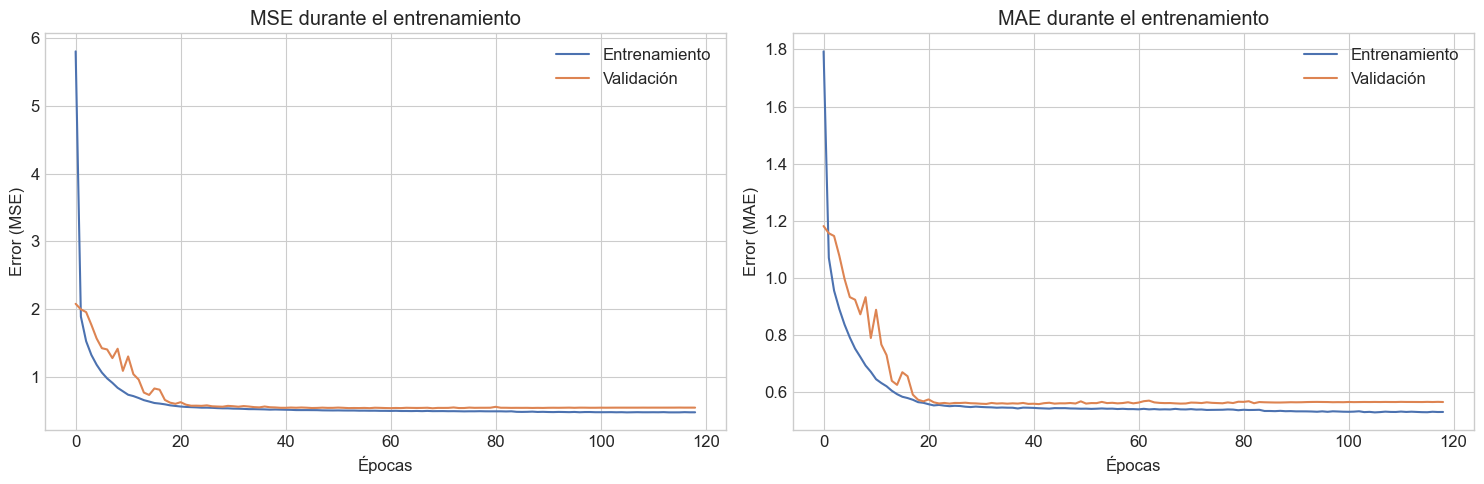

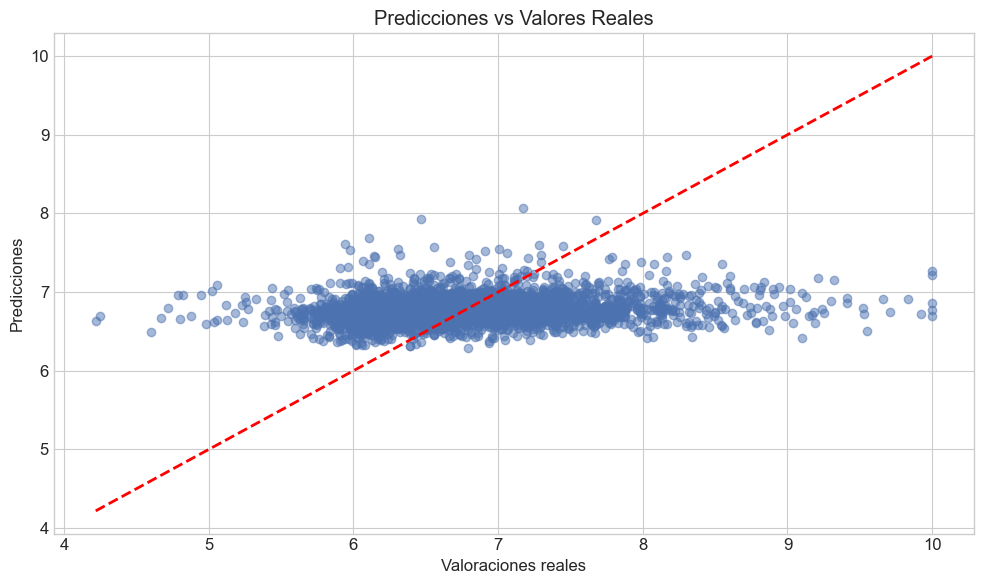

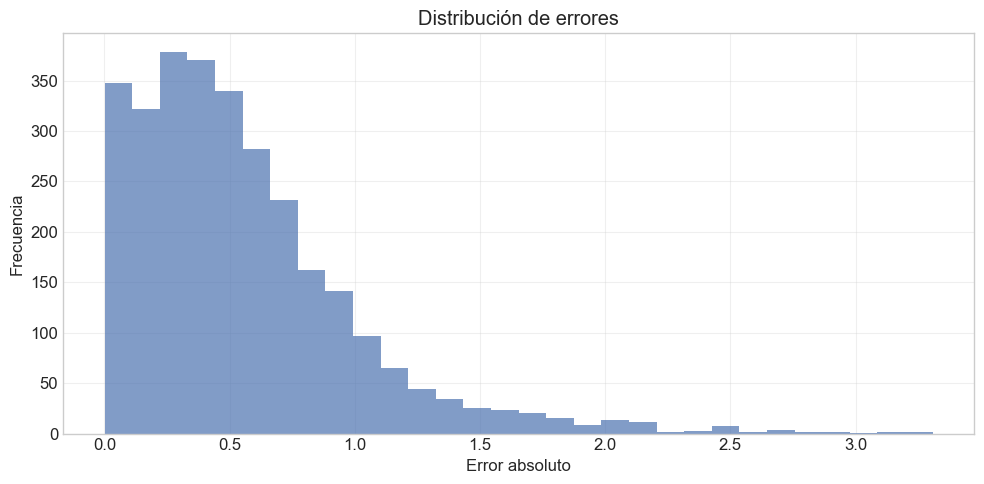

Los 10 casos con peor predicción:


,player,date,original_rating,next_rating,prediccion,error
11847,Willian,30/09/2017,6.35,10.00,6.692294,3.307706
40826,Serge Gnabry,27/04/2018,7.38,10.00,6.778128,3.221872
39577,Tim Kleindienst,16/04/2018,6.27,9.92,6.725339,3.194661
7505,Sergio Aguero,09/09/2017,8.87,10.00,6.863707,3.136293
7468,Yoric Ravet,09/09/2017,5.38,9.55,6.511728,3.038272
9341,Thorgan Hazard,19/09/2017,7.41,9.71,6.747699,2.962301
35059,Steve Mounie,10/03/2018,7.25,9.83,6.916900,2.913100
18543,Wilfried Zaha,25/11/2017,7.44,9.53,6.716013,2.813987
23408,Sergio Aguero,16/12/2017,6.56,10.00,7.214447,2.785553
10469,Sergio Aguero,23/09/2017,8.94,9.66,6.911895,2.748105


In [43]:
# Función mejorada para visualizar el proceso de entrenamiento
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfica de pérdida
    ax[0].plot(history.history['loss'], label='Entrenamiento')
    ax[0].plot(history.history['val_loss'], label='Validación')
    ax[0].set_title('MSE durante el entrenamiento')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Error (MSE)')
    ax[0].legend()
    ax[0].grid(True)
    
    # Gráfica de MAE
    ax[1].plot(history.history['mae'], label='Entrenamiento')
    ax[1].plot(history.history['val_mae'], label='Validación')
    ax[1].set_title('MAE durante el entrenamiento')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Error (MAE)')
    ax[1].legend()
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Visualizar el historial de entrenamiento
plot_training_history(history)

# Visualización mejorada de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valoraciones reales")
plt.ylabel("Predicciones")
plt.grid(True)
plt.tight_layout()
plt.show()

# Análisis de los errores
errores = abs(y_test - y_pred.flatten())
df_errores = test_df.copy()
df_errores['prediccion'] = y_pred.flatten()
df_errores['error'] = errores

# Histograma de errores
plt.figure(figsize=(10, 5))
plt.hist(errores, bins=30, alpha=0.7)
plt.title("Distribución de errores")
plt.xlabel("Error absoluto")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Ver los peores errores
print("Los 10 casos con peor predicción:")
errores_ordenados = df_errores.sort_values(by='error', ascending=False).head(10)
errores_ordenados[['player', 'date', 'original_rating', 'next_rating', 'prediccion', 'error']]

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step


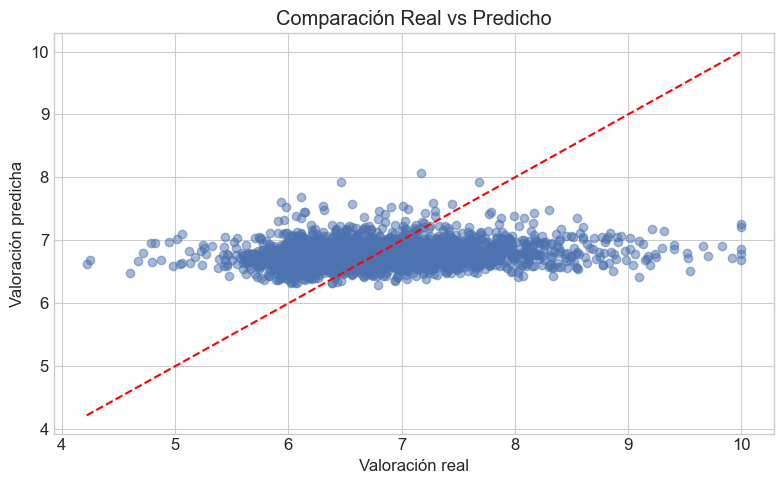

In [44]:
y_pred = modelo.predict(X_test_selected).flatten()

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Línea de igualdad
plt.xlabel("Valoración real")
plt.ylabel("Valoración predicha")
plt.title("Comparación Real vs Predicho")
plt.grid(True)
plt.tight_layout()
plt.show()


In [45]:
errores = abs(y_test - y_pred)
df_errores = test_df.copy()
df_errores['prediccion'] = y_pred
df_errores['error'] = errores

# Ver los peores errores
df_errores.sort_values(by='error', ascending=False).head(10)


,competition,date,match,team,pos,pos_role,player,rater,original_rating,goals,...,ratio_duelos,eficacia_tiro,pos_vs_media,goals_por90,assists_por90,shots_ontarget_por90,keypasses_por90,tackles_por90,prediccion,error
11847,Premier League 2017-18,30/09/2017,"Chelsea - Manchester City, 0 - 1",Chelsea,4,Sub,Willian,WhoScored,6.35,0,...,0.600000,0.00000,0.057224,0.0,0.0,0.000000,0.0,0.0,6.692294,3.307706
40826,Bundesliga 2017-18,27/04/2018,"Hoffenheim - Hannover 96, 3 - 1",Hoffenheim,2,MC,Serge Gnabry,WhoScored,7.38,0,...,0.571429,0.00000,0.463362,0.0,4.5,0.000000,0.0,4.5,6.778128,3.221872
39577,Bundesliga 2017-18,16/04/2018,"Mainz 05 - Freiburg, 2 - 0",Freiburg,4,Sub,Tim Kleindienst,WhoScored,6.27,0,...,0.368421,0.00000,-0.022776,0.0,0.0,0.000000,0.0,0.0,6.725339,3.194661
7505,Premier League 2017-18,09/09/2017,"Manchester City - Liverpool, 5 - 0",Manchester City,3,FW,Sergio Aguero,WhoScored,8.87,1,...,0.461538,0.47619,1.835762,1.0,1.0,2.000000,0.0,0.0,6.863707,3.136293
7468,Bundesliga 2017-18,09/09/2017,"Freiburg - Borussia Dortmund, 0 - 0",Freiburg,2,MR,Yoric Ravet,WhoScored,5.38,0,...,0.250000,0.00000,-1.536638,0.0,0.0,0.000000,1.0,0.0,6.511728,3.038272
9341,Bundesliga 2017-18,19/09/2017,"Borussia M.Gladbach - VfB Stuttgart, 2 - 0",Borussia M.Gladbach,2,ML,Thorgan Hazard,WhoScored,7.41,0,...,0.333333,0.00000,0.493362,0.0,0.0,0.000000,1.0,0.0,6.747699,2.962301
35059,Premier League 2017-18,10/03/2018,"Huddersfield - Swansea, 0 - 0",Huddersfield,3,FW,Steve Mounie,WhoScored,7.25,0,...,0.421053,0.00000,0.215762,0.0,0.0,3.000000,0.0,0.0,6.916900,2.913100
18543,Premier League 2017-18,25/11/2017,"Crystal Palace - Stoke, 2 - 1",Crystal Palace,3,FW,Wilfried Zaha,WhoScored,7.44,0,...,0.562500,0.00000,0.405762,0.0,0.0,0.000000,3.0,4.0,6.716013,2.813987
23408,Premier League 2017-18,16/12/2017,"Manchester City - Tottenham, 4 - 1",Manchester City,3,FW,Sergio Aguero,WhoScored,6.56,0,...,0.461538,0.00000,-0.474238,0.0,0.0,1.578947,0.0,0.0,7.214447,2.785553
10469,Premier League 2017-18,23/09/2017,"Manchester City - Crystal Palace, 5 - 0",Manchester City,3,FW,Sergio Aguero,WhoScored,8.94,1,...,0.555556,0.47619,1.905762,1.0,1.0,2.000000,1.0,0.0,6.911895,2.748105


In [46]:
# Guardado del modelo mejorado
modelo.save("modelo_rating_futbol_mejorado.keras")
print("Modelo guardado correctamente como 'modelo_rating_futbol_mejorado.keras'")

def predecir_valoracion_mejorada(jugador: str, df, features, modelo, imputer, scaler, selector):
    """
    Predice la valoración del próximo partido de un jugador específico
    usando su último partido registrado en el DataFrame `df`.
    
    Versión mejorada con preprocesamiento completo.

    Parámetros:
    - jugador: nombre del jugador (str)
    - df: DataFrame original con todos los datos
    - features: lista de columnas usadas como entrada del modelo
    - modelo: modelo Keras entrenado
    - imputer: SimpleImputer entrenado
    - scaler: RobustScaler entrenado
    - selector: SelectKBest entrenado

    Retorna:
    - Predicción (float) o mensaje si no hay datos suficientes
    """
    historial = df[df['player'] == jugador].copy().sort_values(by='date')

    if len(historial) == 0:
        print(f"⚠️ No hay partidos disponibles para {jugador}.")
        return None

    ultimo_partido = historial.iloc[-1]
    
    # Posición del jugador para mostrar información adicional
    posicion_num = ultimo_partido['pos']
    pos_map_inv = {0: 'GK', 1: 'DF', 2: 'MF', 3: 'FW', 4: 'Sub'}
    posicion = pos_map_inv.get(posicion_num, 'Desconocida')
    
    # Datos para predicción
    input_data = ultimo_partido[features].values.reshape(1, -1)
    
    # Aplicamos el mismo preprocesamiento que durante el entrenamiento
    input_imputed = imputer.transform(input_data)
    input_scaled = scaler.transform(input_imputed)
    input_selected = selector.transform(input_scaled)
    
    # Realizamos la predicción
    prediccion = modelo.predict(input_selected)[0][0]
    
    # Valoración actual como referencia
    rating_actual = ultimo_partido['original_rating']
    
    # Mostramos resultado
    print(f"═══════════════════════════════════")
    print(f"📊 Predicción para {jugador} ({posicion})")
    print(f"═══════════════════════════════════")
    print(f"Valoración actual: {rating_actual:.2f}")
    print(f"Predicción próxima valoración: {prediccion:.2f}")
    
    # Análisis de tendencia
    cambio = prediccion - rating_actual
    if cambio > 0.3:
        print(f"\n   • Pronóstico: 📈 Se espera una MEJORA en rendimiento (+{cambio:.2f})")
    elif cambio < -0.3:
        print(f"\n   • Pronóstico: 📉 Se espera un DESCENSO en rendimiento ({cambio:.2f})")
    else:
        print(f"\n   • Pronóstico: ↔️ Se espera un rendimiento ESTABLE ({cambio:.2f})")
    
    print("═══════════════════════════════════")
    
    return prediccion

# Ejemplo de uso
predecir_valoracion_mejorada('Nemanja Matic', df, features, modelo, imputer, robust_scaler, selector)

Modelo guardado correctamente como 'modelo_rating_futbol_mejorado.keras'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
═══════════════════════════════════
📊 Predicción para Nemanja Matic (MF)
═══════════════════════════════════
Valoración actual: 6.72
Predicción próxima valoración: 6.96

   • Pronóstico: ↔️ Se espera un rendimiento ESTABLE (0.24)
═══════════════════════════════════
═══════════════════════════════════
📊 Predicción para Nemanja Matic (MF)
═══════════════════════════════════
Valoración actual: 6.72
Predicción próxima valoración: 6.96

   • Pronóstico: ↔️ Se espera un rendimiento ESTABLE (0.24)
═══════════════════════════════════


C:\Users\Santiago\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


6.9577785

# Visualización de datos de validación para jugadores seleccionados

Esta celda permite visualizar el historial y los datos de validación de cualquier jugador específico en el conjunto de datos. Esto nos ayudará a entender mejor cómo está funcionando el modelo para casos particulares.

In [47]:
def visualizar_datos_jugador(jugador: str, df, train_df, val_df, test_df):
    """
    Visualiza los datos históricos, de entrenamiento y validación para un jugador específico.
    
    Parámetros:
    - jugador: nombre del jugador a analizar
    - df: DataFrame completo
    - train_df, val_df, test_df: DataFrames de entrenamiento, validación y prueba
    """
    # Filtrar datos del jugador
    datos_jugador = df[df['player'] == jugador].copy().sort_values(by='date')
    
    if len(datos_jugador) == 0:
        print(f"⚠️ No hay datos disponibles para {jugador}")
        return
    
    # Identificar a qué conjunto pertenece cada partido
    datos_jugador['conjunto'] = 'Desconocido'
    
    # Marcar los índices en cada conjunto
    indices_train = train_df.index
    indices_val = val_df.index
    indices_test = test_df.index
    
    for idx in datos_jugador.index:
        if idx in indices_train:
            datos_jugador.loc[idx, 'conjunto'] = 'Entrenamiento'
        elif idx in indices_val:
            datos_jugador.loc[idx, 'conjunto'] = 'Validación'
        elif idx in indices_test:
            datos_jugador.loc[idx, 'conjunto'] = 'Prueba'
    
    # Posición del jugador
    pos_map_inv = {0: 'Portero (GK)', 1: 'Defensa (DF)', 2: 'Centrocampista (MF)', 
                   3: 'Delantero (FW)', 4: 'Suplente (Sub)'}
    posicion = pos_map_inv.get(datos_jugador['pos'].iloc[0], 'Desconocida')
    
    # Información general
    print(f"═══════════════════════════════════════════════════")
    print(f"📊 Datos de {jugador} ({posicion})")
    print(f"═══════════════════════════════════════════════════")
    print(f"Total de partidos: {len(datos_jugador)}")
    
    # Distribución por conjunto
    dist_conjuntos = datos_jugador['conjunto'].value_counts()
    print("\nDistribución por conjunto:")
    for conjunto, cantidad in dist_conjuntos.items():
        print(f"   • {conjunto}: {cantidad} partidos")
    
    # Estadísticas básicas
    print("\nEstadísticas de valoración:")
    stats = datos_jugador['original_rating'].describe()
    print(f"   • Media: {stats['mean']:.2f}")
    print(f"   • Mínima: {stats['min']:.2f}")
    print(f"   • Máxima: {stats['max']:.2f}")
    print(f"   • Desviación estándar: {stats['std']:.2f}")
    
    # Visualizar serie temporal de valoraciones
   
    
    # Visualización del historial de valoraciones en tabla
    print("\nÚltimos 10 partidos:")
    ultimos_partidos = datos_jugador.tail(10)[['date', 'original_rating', 'next_rating', 'conjunto']]
    display(ultimos_partidos)
    # Si hay partidos en el conjunto de validación, mostrarlos en detalle
    val_partidos = datos_jugador[datos_jugador['conjunto'] == 'Validación']
    if len(val_partidos) > 0:
        print("\nDetalle de partidos en conjunto de validación:")
        display(val_partidos[['date', 'original_rating', 'next_rating']])
        
        # Métricas relevantes para conjunto de validación
        cols_relevantes = ['original_rating', 'goals', 'assists', 'shots_ontarget', 
                         'passes_acc', 'keypasses', 'rating_avg_3', 'rating_trend']
        
        # Solo mostrar las columnas que existan en el DataFrame
        cols_disponibles = [col for col in cols_relevantes if col in val_partidos.columns]
        
        print("\nEstadísticas clave en partidos de validación:")
        display(val_partidos[cols_disponibles].describe().round(2))
    
    # Si el jugador tiene predicciones en el conjunto de prueba, mostrarlas
    partidos_test = datos_jugador[datos_jugador['conjunto'] == 'Prueba']
    if len(partidos_test) > 0:
        # Verificar si hay predicciones para estos partidos en df_errores
        if 'df_errores' in globals():
            pred_test = df_errores[df_errores['player'] == jugador]
            if len(pred_test) > 0:
                print("\nPredicciones en conjunto de prueba:")
                display(pred_test[['date', 'original_rating', 'next_rating', 'prediccion', 'error']])
                
                # Calculamos MAE para este jugador específico
                mae_jugador = pred_test['error'].mean()
                print(f"\nMAE específico para {jugador}: {mae_jugador:.4f}")
    
    return datos_jugador

# Ejemplo de uso
jugador_seleccionado = 'Nemanja Matic'  # Puedes cambiar por cualquier otro jugador
datos_jugador = visualizar_datos_jugador(jugador_seleccionado, df, train_df, val_df, test_df)

═══════════════════════════════════════════════════
📊 Datos de Nemanja Matic (Centrocampista (MF))
═══════════════════════════════════════════════════
Total de partidos: 38

Distribución por conjunto:
   • Validación: 29 partidos
   • Entrenamiento: 9 partidos

Estadísticas de valoración:
   • Media: 7.17
   • Mínima: 5.99
   • Máxima: 8.56
   • Desviación estándar: 0.52

Últimos 10 partidos:


,date,original_rating,next_rating,conjunto
18605,25/11/2017,7.02,7.58,Validación
6365,26/08/2017,7.58,6.93,Validación
24738,26/12/2017,6.93,6.85,Validación
48671,27/06/2018,6.85,7.05,Validación
15293,28/10/2017,7.05,6.68,Validación
19187,28/11/2017,6.68,7.05,Validación
41848,29/04/2018,7.05,7.17,Validación
11579,30/09/2017,7.17,7.52,Validación
25153,30/12/2017,7.52,6.72,Validación
29440,31/01/2018,6.72,7.34,Validación



Detalle de partidos en conjunto de validación:


,date,original_rating,next_rating
21773,10/12/2017,6.99,6.82
31617,11/02/2018,6.82,8.30
4585,13/08/2017,8.30,7.15
22737,13/12/2017,7.15,7.01
13035,14/10/2017,7.01,7.30
27211,15/01/2018,7.30,5.99
39495,15/04/2018,5.99,7.06
45336,17/06/2018,7.06,7.95
9219,17/09/2017,7.95,6.80
23860,17/12/2017,6.80,6.27



Estadísticas clave en partidos de validación:


,original_rating,goals,assists,shots_ontarget,passes_acc,keypasses,rating_avg_3,rating_trend
count,29.00,29.0,29.00,29.00,29.00,29.00,29.00,29.00
mean,7.08,0.0,0.03,0.03,59.62,0.10,7.09,-0.01
std,0.49,0.0,0.19,0.19,23.66,0.31,0.23,0.61
min,5.99,0.0,0.00,0.00,15.00,0.00,6.66,-1.16
25%,6.81,0.0,0.00,0.00,42.00,0.00,6.93,-0.33
50%,7.05,0.0,0.00,0.00,55.00,0.00,7.07,-0.19
75%,7.30,0.0,0.00,0.00,75.00,0.00,7.26,0.29
max,8.30,0.0,1.00,1.00,111.00,1.00,7.49,1.31
